# Mounting and Importing library

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


In [ ]:
# pip install monai
# pip install dicom2nifti
# pip install SimpleITK
# pip install nibabel
# pip install glob2
# pip install tqdm
# pip install shutil
# pip install pydicom

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm 
from glob import glob
import shutil
import dicom2nifti
import numpy as np
import nibabel as nib
import pytest
import pydicom
from pydicom.dataset import Dataset
from pydicom.uid import generate_uid

In [ ]:
import torch
print(torch.__version__)

2.5.1+cu124


In [ ]:
# import monai functions
from monai.utils import first
from monai.losses import DiceLoss
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism

from monai.transforms import (
    Compose,
    EnsureChannelFirstD,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)


#  Clean Data

In [ ]:
# Step 1: Convert NIfTI to DICOM Slices

In [ ]:
import os
import nibabel as nib
import numpy as np
import pydicom
from pydicom.dataset import Dataset
from datetime import datetime

def nifti_to_dicom(nifti_path, output_dicom_dir, patient_id="12345", study_desc="NIfTI to DICOM Conversion"):
    """
    Convert a NIfTI (.nii or .nii.gz) file to a series of DICOM (.dcm) slices.
    
    Args:
        nifti_path (str): Path to the input NIfTI file.
        output_dicom_dir (str): Directory to save the DICOM slices.
        patient_id (str): Patient ID (default: "12345").
        study_desc (str): Description of the study (default: "NIfTI to DICOM Conversion").
    """
    # Create output directory if not exists
    os.makedirs(output_dicom_dir, exist_ok=True)

    # Load NIfTI file
    nifti_img = nib.load(nifti_path)
    nifti_data = nifti_img.get_fdata()  # Get pixel array (3D)
    affine = nifti_img.affine  # Get spatial transformation matrix

    # Normalize data to 12-bit (DICOM uses 12-16 bits usually)
    nifti_data = (nifti_data - np.min(nifti_data)) / (np.max(nifti_data) - np.min(nifti_data)) * 4095   
    nifti_data = nifti_data.astype(np.uint16)  # Convert to 16-bit integers

    # Get image dimensions
    num_slices = nifti_data.shape[2]  # Assuming (Height, Width, Depth)

    # Generate DICOM slices
    for i in range(num_slices):
        slice_data = nifti_data[:, :, i]  # Extract 2D slice
        
        # Create DICOM metadata
        ds = Dataset()
        ds.PatientID = patient_id
        ds.PatientName = "Anonymous"
        ds.StudyDescription = study_desc
        ds.Modality = "CT"
        ds.SeriesInstanceUID = pydicom.uid.generate_uid()
        ds.SOPInstanceUID = pydicom.uid.generate_uid()
        ds.StudyInstanceUID = pydicom.uid.generate_uid()
        ds.SeriesNumber = 1
        ds.InstanceNumber = i + 1
        ds.ImagePositionPatient = [affine[0, 3], affine[1, 3], affine[2, 3] + i]
        ds.Rows, ds.Columns = slice_data.shape
        ds.PhotometricInterpretation = "MONOCHROME2"
        ds.SamplesPerPixel = 1
        ds.BitsAllocated = 16
        ds.BitsStored = 12
        ds.HighBit = 11
        ds.PixelRepresentation = 0
        ds.RescaleIntercept = 0
        ds.RescaleSlope = 1
        ds.PixelData = slice_data.tobytes()

        # Save as DICOM file
        dicom_filename = os.path.join(output_dicom_dir, f"slice-{i:04d}.dcm")
        ds.save_as(dicom_filename)

    print(f"Conversion completed: {num_slices} DICOM slices saved in {output_dicom_dir}")

In [ ]:
# usage
nifti_file =  "/content/gdrive/My Drive/Project1_liver/Dataset_liver01"
dicom_output_folder = "/content/gdrive/My Drive/Project1_liver/Dataset_liver_Decom"
nifti_to_dicom(nifti_file, dicom_output_folder)

In [ ]:
# Step 2: Standardize the Number of Slices inside Volume

In [ ]:
import scipy.ndimage

def resample_dicom_slices(dicom_dir, output_dir, target_slices=64):
    """
    Resample a DICOM series to a fixed number of slices.

    Args:
        dicom_dir (str): Path to the directory containing DICOM series.
        output_dir (str): Path to save resampled DICOM slices.
        target_slices (int): Fixed number of slices for standardization.

    Returns:
        None
    """
    os.makedirs(output_dir, exist_ok=True)

    # Load DICOM slices and sort them by InstanceNumber 
    dicom_files = [pydicom.dcmread(os.path.join(dicom_dir, f)) for f in os.listdir(dicom_dir) if f.endswith(".dcm")]
    dicom_files.sort(key=lambda d: d.InstanceNumber)  # Ensure slices are in order

    # Convert DICOM images to 3D numpy array
    original_slices = len(dicom_files)
    pixel_array = np.stack([d.pixel_array for d in dicom_files], axis=-1)

    # Compute resampling factor
    zoom_factor = target_slices / original_slices
    resampled_volume = scipy.ndimage.zoom(pixel_array, (1, 1, zoom_factor), order=1)  # Linear interpolation

    # Save resampled slices as new DICOM series
    for i in range(target_slices):
        new_slice = dicom_files[0]  # Copy metadata from first slice
        new_slice.PixelData = resampled_volume[:, :, i].astype(np.uint16).tobytes()
        new_slice.InstanceNumber = i + 1  # Update slice number
        new_slice.SOPInstanceUID = pydicom.uid.generate_uid()  # Generate unique ID
        new_slice.save_as(os.path.join(output_dir, f"resampled-{i:03d}.dcm"))

    print(f"Resampled {original_slices} slices to {target_slices} slices and saved to {output_dir}")



In [ ]:
#  usage
dicom_input_dir = "/content/gdrive/My Drive/Project1_liver/Dataset_liver_Decom"
dicom_output_dir = "/content/gdrive/My Drive/Project1_liver/resampled_dicom_series"
target_num_slices = 64
resample_dicom_slices(dicom_input_dir, dicom_output_dir, target_num_slices)

In [ ]:
# Step 3: Convert Standardized DICOM Back to NIfTI

In [ ]:
import os
import SimpleITK as sitk

def convert_all_dicom_folders(parent_folder, output_nifti_dir):
    """ Convert all DICOM folders in a parent folder to NIfTI files. 
    it will convert all the DICOM folders in the parent folder to NIfTI files. """
    # Ensure output directory exists
    os.makedirs(output_nifti_dir, exist_ok=True)

    # Loop through each volume folder
    for volume_folder in sorted(os.listdir(parent_folder)):
        dicom_folder = os.path.join(parent_folder, volume_folder)

        # Check if it's a directory
        if os.path.isdir(dicom_folder):
            output_nifti_path = os.path.join(output_nifti_dir, f"{volume_folder}.nii.gz")

            # Convert DICOM to NIfTI
            reader = sitk.ImageSeriesReader()
            dicom_files = reader.GetGDCMSeriesFileNames(dicom_folder)
            reader.SetFileNames(dicom_files)

            image = reader.Execute()
            sitk.WriteImage(image, output_nifti_path)

            print(f"Converted {volume_folder} to {output_nifti_path}")

In [ ]:
# Example usage

# input dicom folder path which resampled, for both Volume and Segmentation(Mask)
dicom_folder_vol = "/content/gdrive/My Drive/Project1_liver/resampled_dicom_series/Decom_vol"
dicom_folder_seg = "/content/gdrive/My Drive/Project1_liver/resampled_dicom_series/Decom_seg"

# output path for Nifti files
standardized_output_nifti_vol = "/content/gdrive/My Drive/Project1_liver/Data_Standardized_Nifty/Nifty_vol"
standardized_output_nifti_seg = "/content/gdrive/My Drive/Project1_liver/Data_Standardized_Nifty/Nifty_seg"

In [ ]:
# convert Volumes
convert_all_dicom_folders(dicom_folder_vol, standardized_output_nifti_vol)

Converted volume-0 to /content/gdrive/My Drive/Project1_liver/Data_Standardized_Nifty/Nifty_vol/volume-0.nii.gz
Converted volume-1 to /content/gdrive/My Drive/Project1_liver/Data_Standardized_Nifty/Nifty_vol/volume-1.nii.gz
Converted volume-2 to /content/gdrive/My Drive/Project1_liver/Data_Standardized_Nifty/Nifty_vol/volume-2.nii.gz
Converted volume-3 to /content/gdrive/My Drive/Project1_liver/Data_Standardized_Nifty/Nifty_vol/volume-3.nii.gz
Converted volume-4 to /content/gdrive/My Drive/Project1_liver/Data_Standardized_Nifty/Nifty_vol/volume-4.nii.gz
Converted volume-5 to /content/gdrive/My Drive/Project1_liver/Data_Standardized_Nifty/Nifty_vol/volume-5.nii.gz


In [ ]:
# convert Labels (Segmentation)
convert_all_dicom_folders(dicom_folder_seg, standardized_output_nifti_seg)

Converted segmentation-0 to /content/gdrive/My Drive/Project1_liver/Data_Standardized_Nifty/Nifty_seg/segmentation-0.nii.gz
Converted segmentation-1 to /content/gdrive/My Drive/Project1_liver/Data_Standardized_Nifty/Nifty_seg/segmentation-1.nii.gz
Converted segmentation-2 to /content/gdrive/My Drive/Project1_liver/Data_Standardized_Nifty/Nifty_seg/segmentation-2.nii.gz
Converted segmentation-3 to /content/gdrive/My Drive/Project1_liver/Data_Standardized_Nifty/Nifty_seg/segmentation-3.nii.gz
Converted segmentation-4 to /content/gdrive/My Drive/Project1_liver/Data_Standardized_Nifty/Nifty_seg/segmentation-4.nii.gz
Converted segmentation-5 to /content/gdrive/My Drive/Project1_liver/Data_Standardized_Nifty/Nifty_seg/segmentation-5.nii.gz


# Preprocess Function

In [ ]:
def prepare(in_dir, pixdim=(1.5, 1.5, 1.0), a_min=-200, a_max=200, spatial_size=[128, 128, 64], cache=False):
    """
    This function is for preprocessing, loading, transforms and caching the dataset.  
    """

    set_determinism(seed=0)

    path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
    path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSegmentation", "*.nii.gz")))

    path_test_volumes = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
    path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestSegmentation", "*.nii.gz")))

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in
                   zip(path_train_volumes, path_train_segmentation)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in
                  zip(path_test_volumes, path_test_segmentation)]

    # Using Compose function of Monai to some proprocess 
    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]), 
            EnsureChannelFirstD(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]), 
            EnsureChannelFirstD(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),
            ToTensord(keys=["vol", "seg"]),

        ]
    )

    # Using Dataloader of Monai , this 
    if cache: 
        train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = Dataset(data=test_files, transform=test_transforms)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader


# Show_patient

In [ ]:
def show_patient(data, SLICE_NUMBER=1, train=True, test=False): 
    check_patient_train, check_patient_test = data
    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)

    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()

    if test:
        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_test_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_test_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()


# Preprocess Data

In [ ]:
# Dataset calling
data_dir = "/content/gdrive/My Drive/Project1_liver/Data_Standardized_Nifty"

# Preprocess data
input_data = prepare(data_dir, cache=False) # output is train_loader, test_loader


# Some Function

In [ ]:
def dice_metric(predicted, target):
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

def calculate_weights(val1, val2):
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)


def calculate_pixels(data):
    "This "
    val = np.zeros((1, 2))

    for batch in tqdm(data):
        batch_label = batch["seg"] != 0
        _, count = np.unique(batch_label, return_counts=True)

        if len(count) == 1:
            count = np.append(count, 0)
        val += count

    print('The last values:', val)
    return val


# Train and Validation Function

In [ ]:
def train(model, input_data, loss, optim, max_epochs, model_dir, test_interval=1 , device=torch.device("cuda:0")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_test = []
    save_metric_train = []
    save_metric_test = []
    train_loader, test_loader = input_data

    # Train part
    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0 
        epoch_metric_train = 0
        for batch_data in train_loader:

            train_step += 1

            volume = batch_data["vol"]
            label = batch_data["seg"]
            label = label != 0
            volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            outputs = model(volume)
            train_loss = loss(outputs, label)
            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(
                f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                f"Train_loss: {train_loss.item():.4f}")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

        print('-'*20)

        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)

        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)


        # Validation part
        if (epoch + 1) % test_interval == 0:
            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0

                for test_data in test_loader:
                    test_step += 1
                    test_volume = test_data["vol"]
                    test_label = test_data["seg"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)

                    test_outputs = model(test_volume)

                    test_loss = loss(test_outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = dice_metric(test_outputs, test_label)
                    epoch_metric_test += test_metric

                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        model_dir, "best_metric_model.pth"))

                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )


    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")


# Models and Architecture Implemetation

In [ ]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm

# model to device GPU
device = torch.device("cuda:0")

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

# Train Dataset

In [ ]:
# Trainig model on small dataset, with small number of epochs

from monai.losses import DiceLoss

model_directory = '/content/gdrive/My Drive/Project1_liver/results/results_01'

loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True) 

num_epochs = 10

# Train model
if __name__ == '__main__':
    train(model, input_data, loss_function, optimizer, max_epochs = num_epochs , model_dir = model_directory)

----------
epoch 1/10
1/5, Train_loss: 0.5443
Train_dice: 0.4557
2/5, Train_loss: 0.5466
Train_dice: 0.4534
3/5, Train_loss: 0.6057
Train_dice: 0.3943
4/5, Train_loss: 0.6054
Train_dice: 0.3946
5/5, Train_loss: 0.6057
Train_dice: 0.3943
--------------------
Epoch_loss: 0.5815
Epoch_metric: 0.4185
test_loss_epoch: 0.6127
test_dice_epoch: 0.3873
current epoch: 1 current mean dice: 0.3873
best mean dice: 0.3873 at epoch: 1
----------
epoch 2/10
1/5, Train_loss: 0.5432
Train_dice: 0.4568
2/5, Train_loss: 0.5456
Train_dice: 0.4544
3/5, Train_loss: 0.6052
Train_dice: 0.3948
4/5, Train_loss: 0.6049
Train_dice: 0.3951
5/5, Train_loss: 0.6052
Train_dice: 0.3948
--------------------
Epoch_loss: 0.5808
Epoch_metric: 0.4192
test_loss_epoch: 0.6113
test_dice_epoch: 0.3887
current epoch: 2 current mean dice: 0.3887
best mean dice: 0.3887 at epoch: 2
----------
epoch 3/10
1/5, Train_loss: 0.5424
Train_dice: 0.4576
2/5, Train_loss: 0.5447
Train_dice: 0.4553
3/5, Train_loss: 0.6048
Train_dice: 0.3952
4

# Test

In [ ]:
from monai.utils import first
from monai.transforms import Compose, LoadImaged, Resized, ToTensord, Spacingd, Orientationd, ScaleIntensityRanged, CropForegroundd, Activations
from monai.data import DataLoader, Dataset
from monai.inferers import sliding_window_inference 

In [ ]:
data_dir = "/content/gdrive/My Drive/Project1_liver/Data_Standardized_Nifty"
model_dir = '/content/gdrive/My Drive/Project1_liver/results/results_01'

In [ ]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

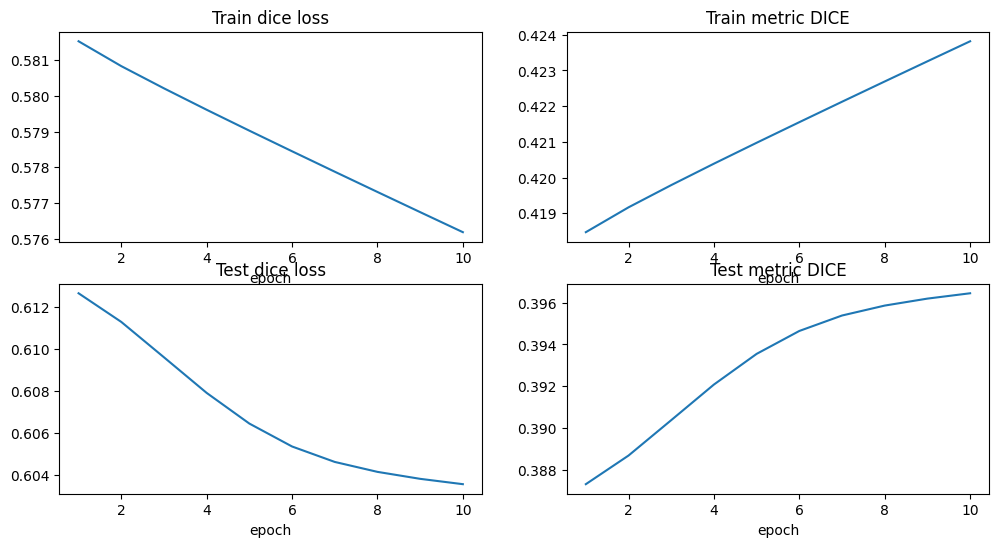

In [ ]:
plt.figure("Results: ", (12, 6))

plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

In [ ]:
path_train_volumes = sorted(glob(os.path.join(data_dir, "TrainVolumes", "*.nii.gz")))
path_train_segmentation = sorted(glob(os.path.join(data_dir, "TrainSegmentation", "*.nii.gz")))

path_test_volumes = sorted(glob(os.path.join(data_dir, "TestVolumes", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(data_dir, "TestSegmentation", "*.nii.gz")))

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]

In [ ]:
#test_files = test_files[0]

In [ ]:
test_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        EnsureChannelFirstD(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),
        ToTensord(keys=["vol", "seg"]),
    ]
)

/usr/local/lib/python3.11/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [ ]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

In [ ]:
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

<ipython-input-49-03d54dd43ce3>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


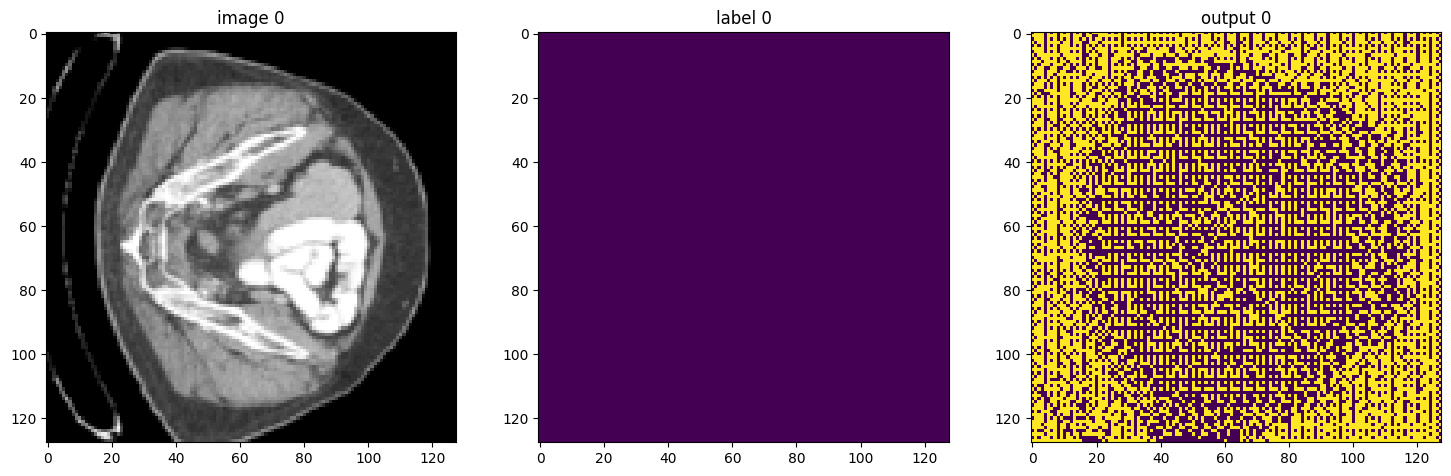

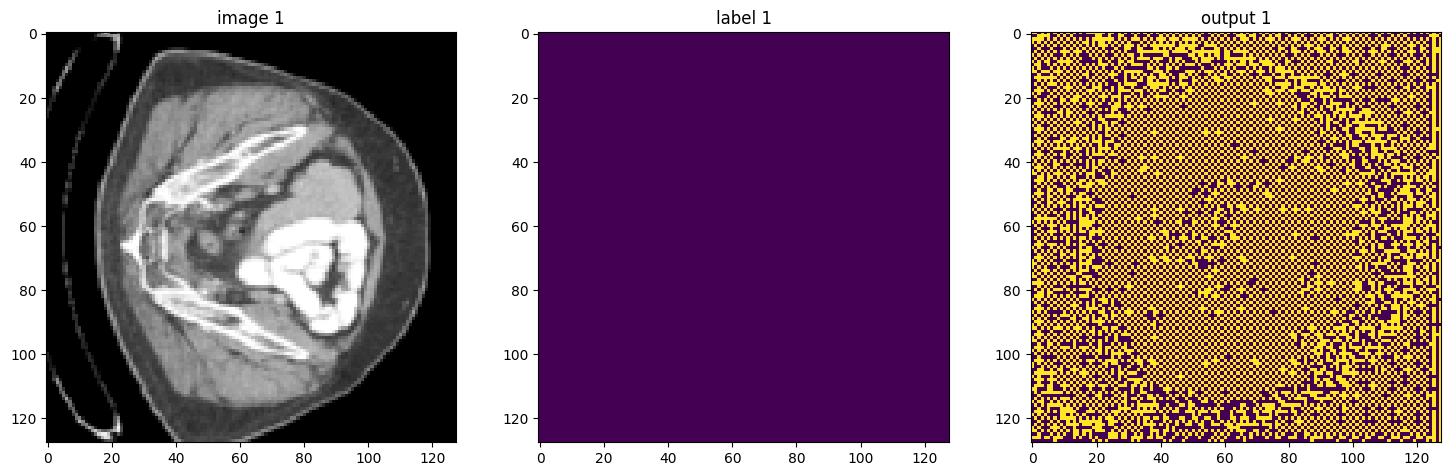

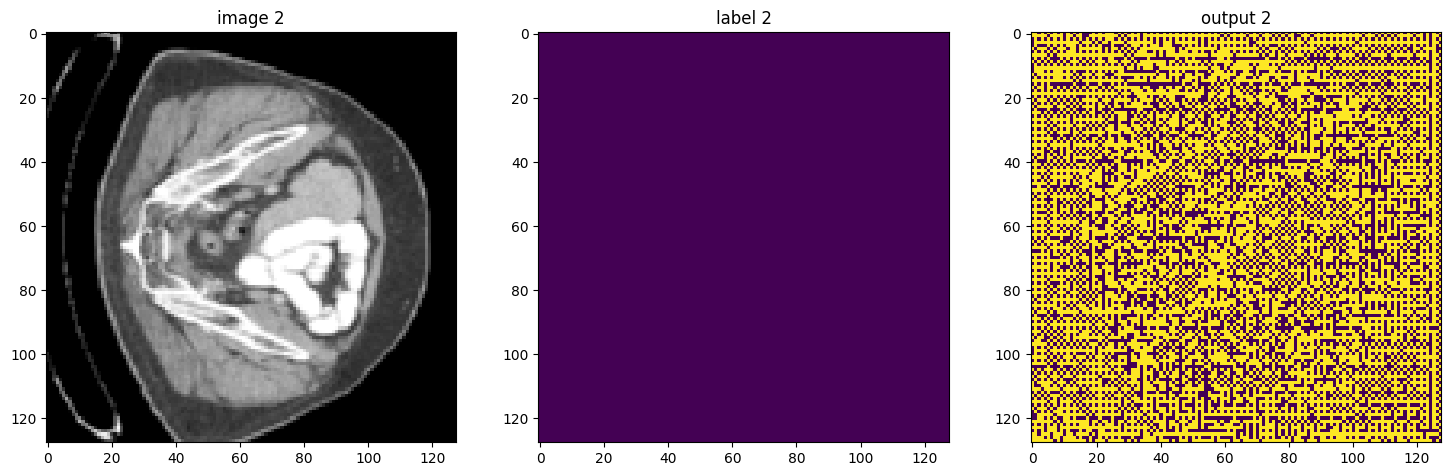

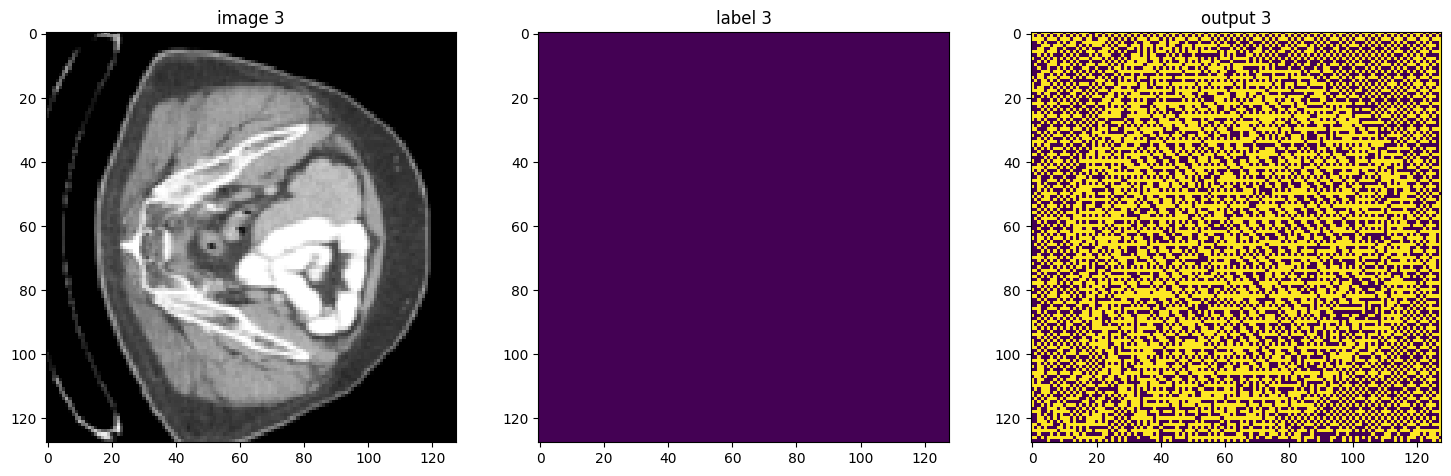

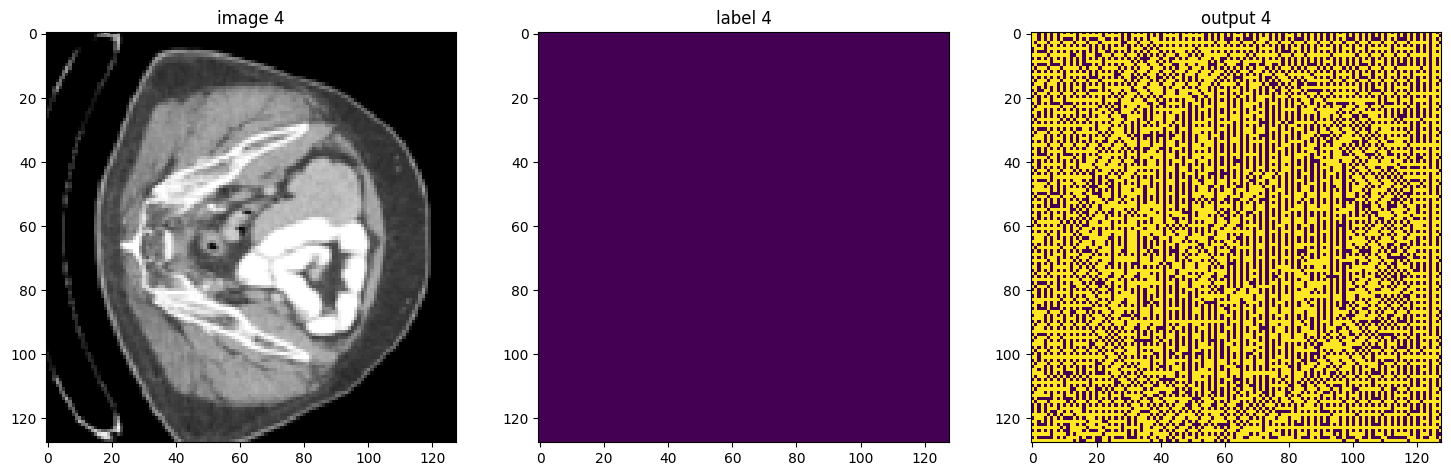

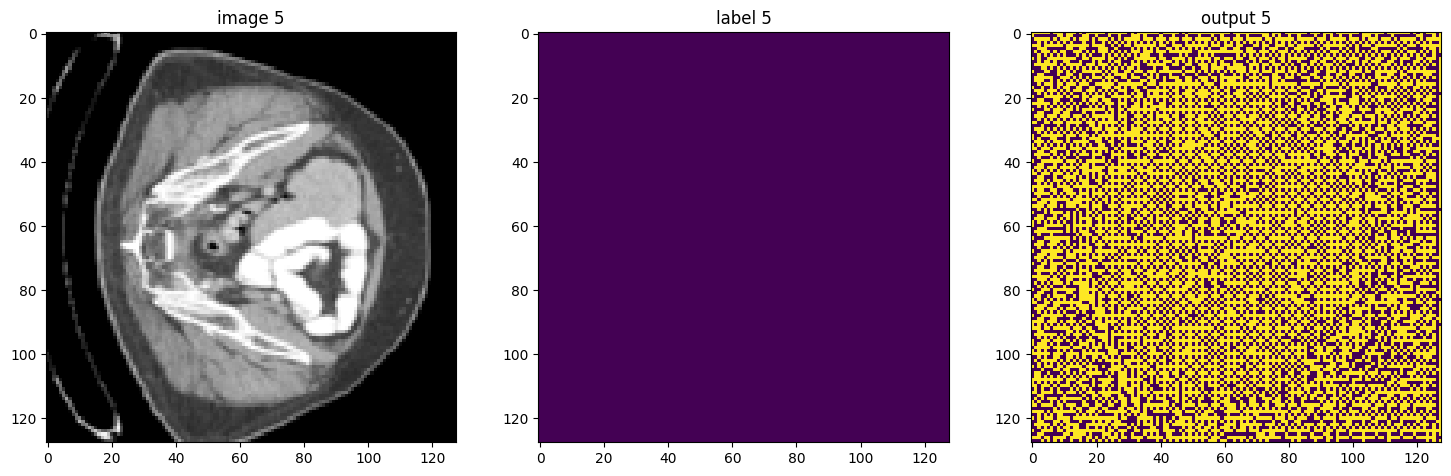

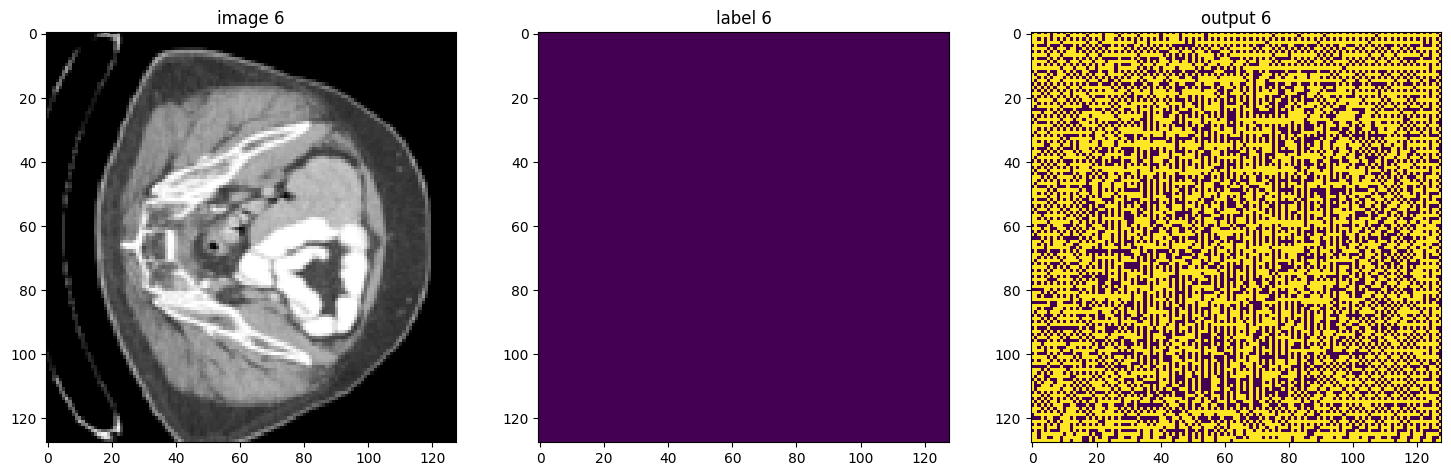

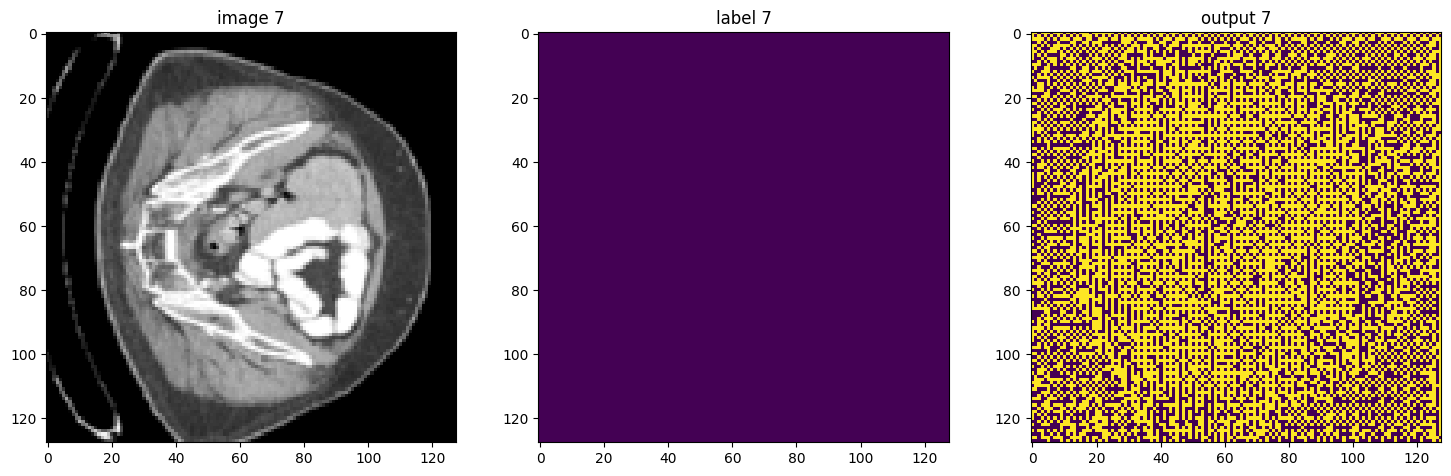

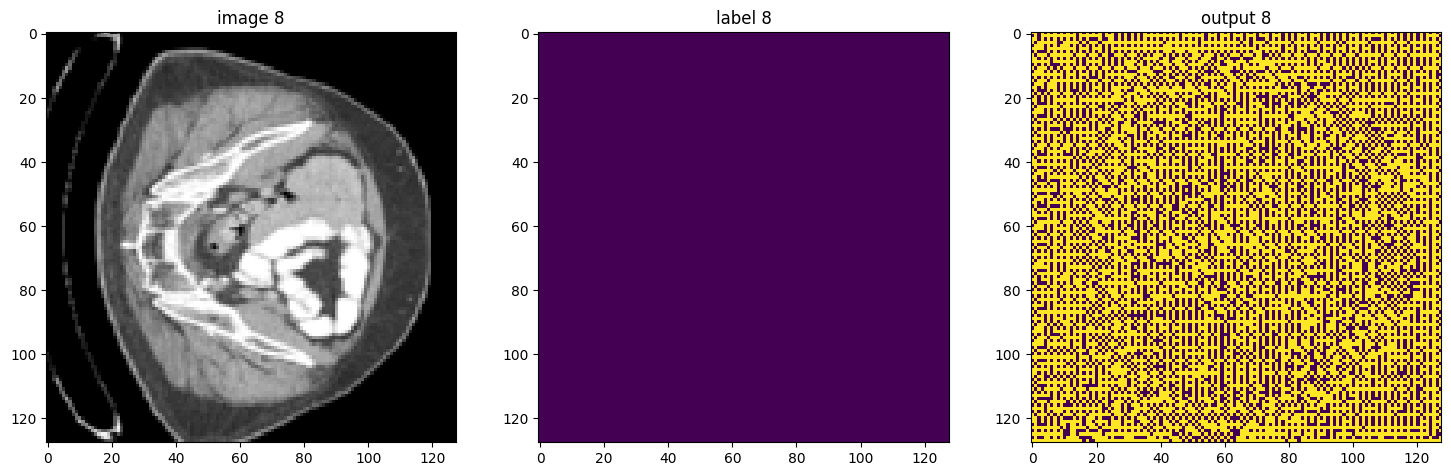

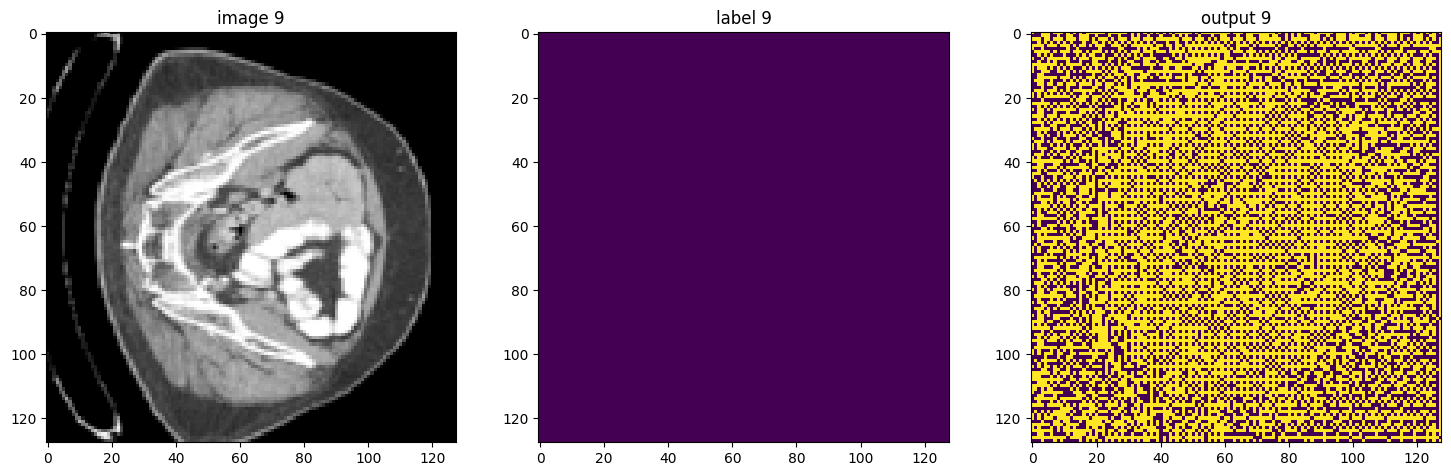

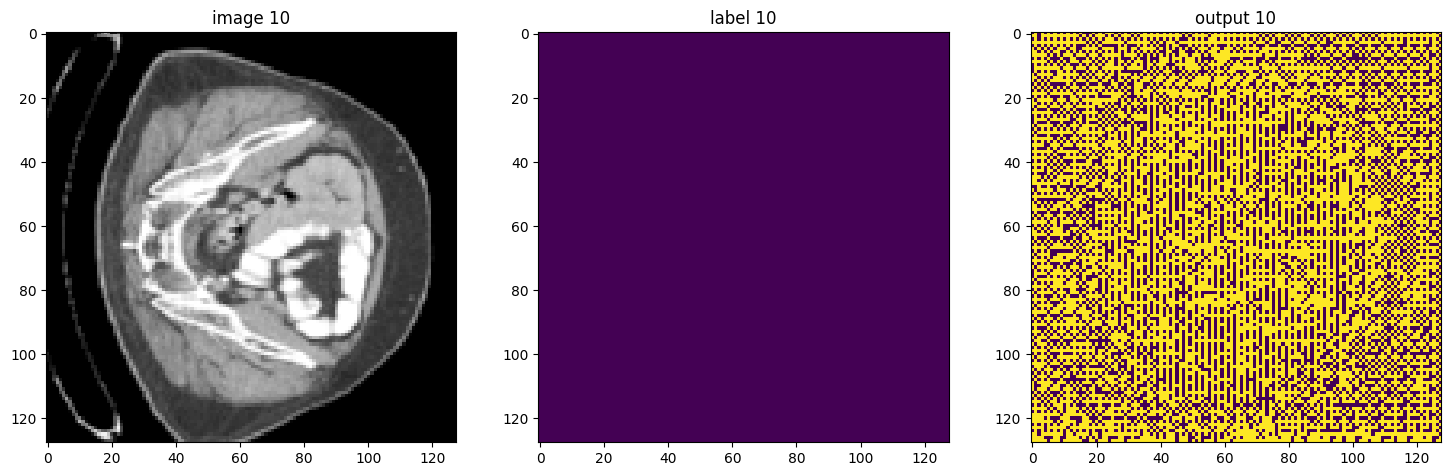

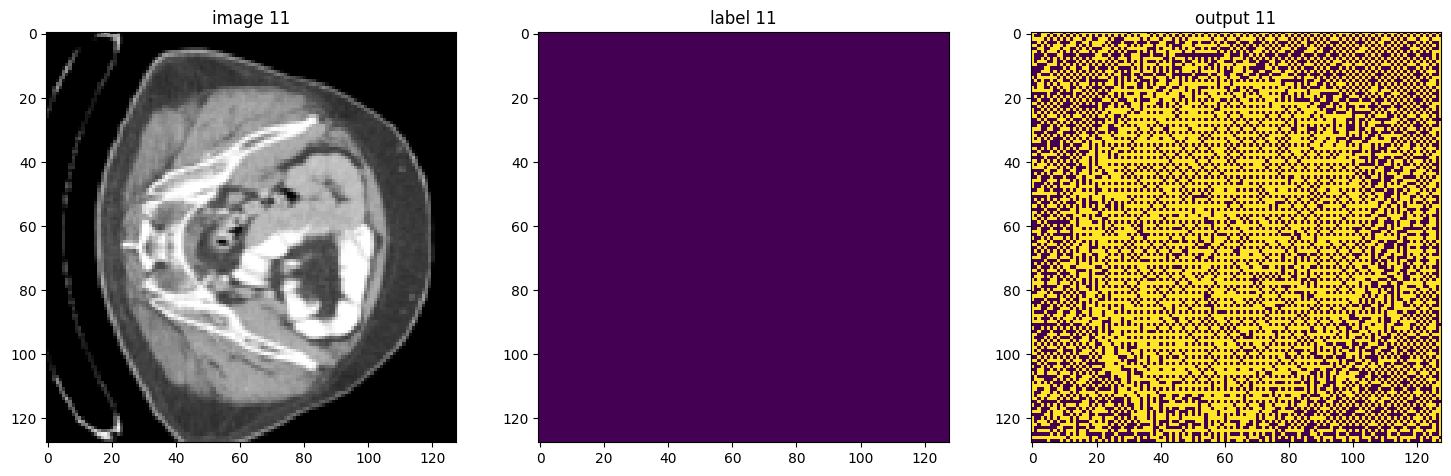

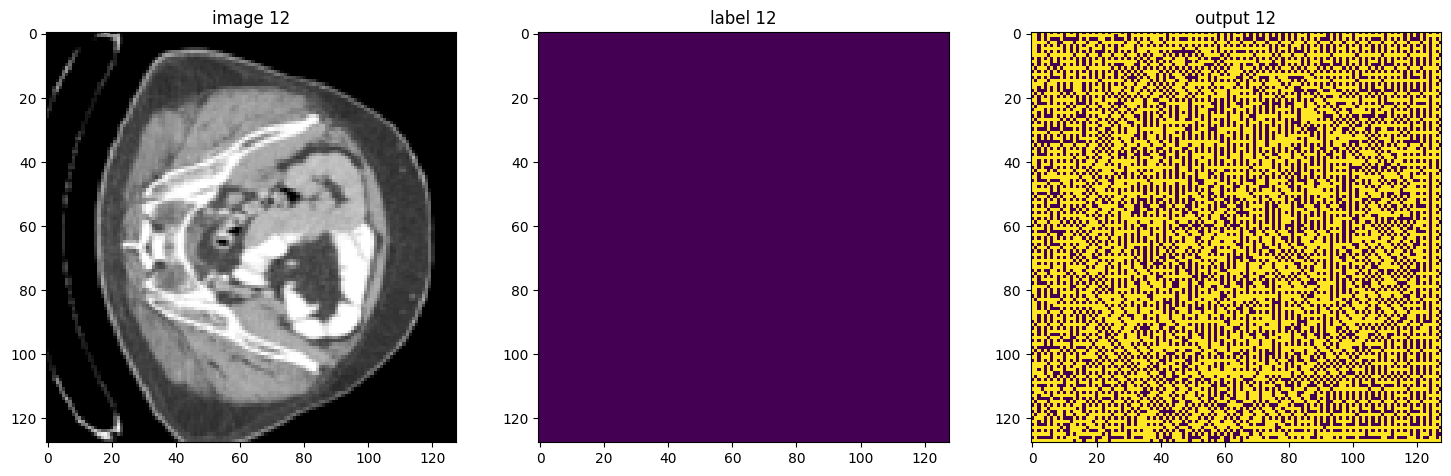

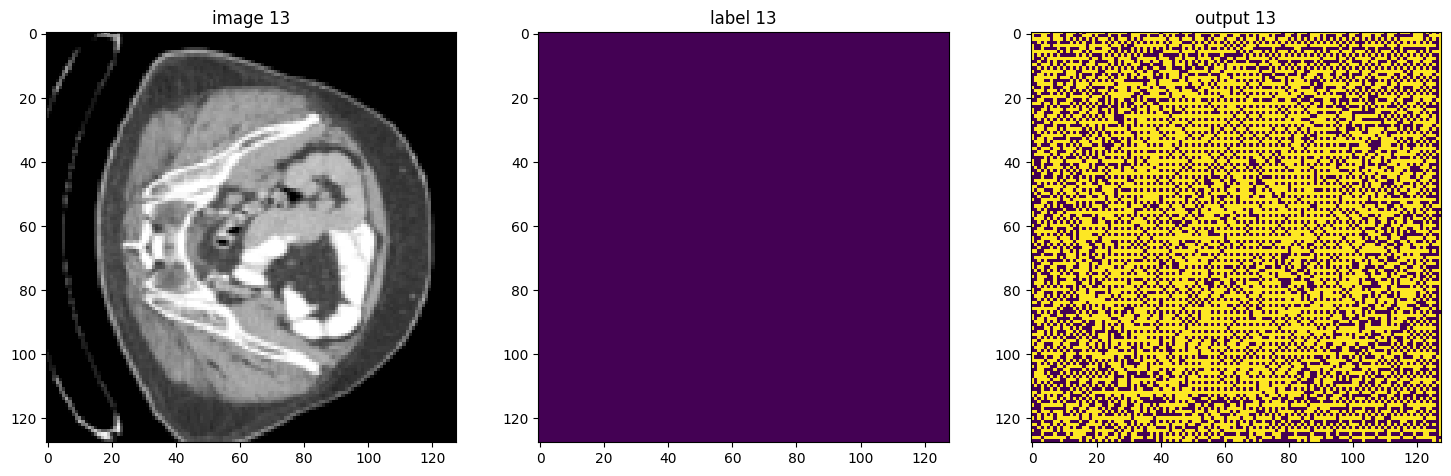

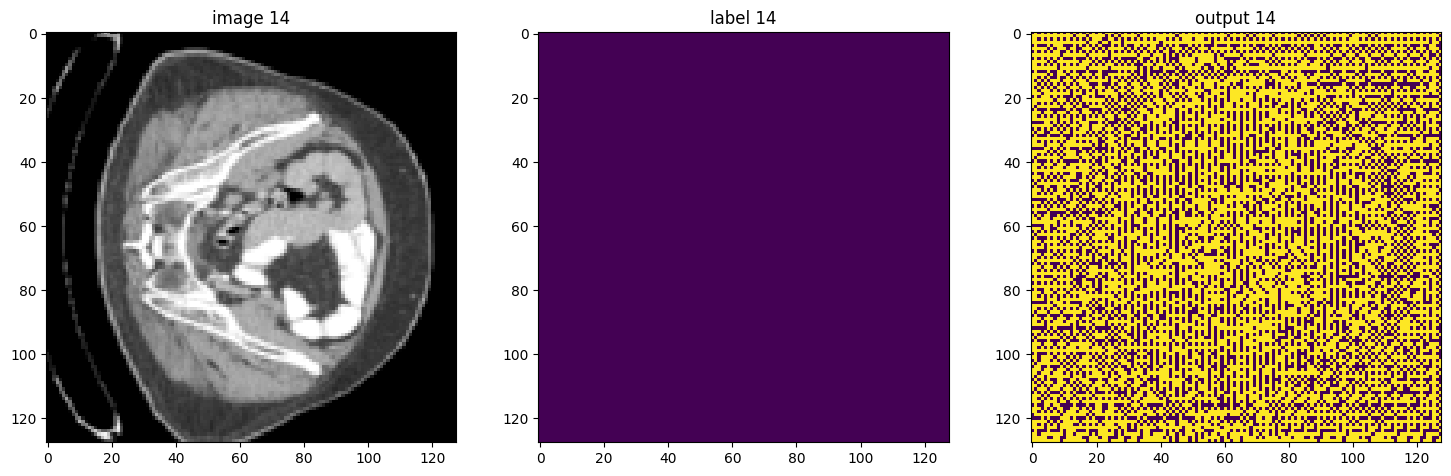

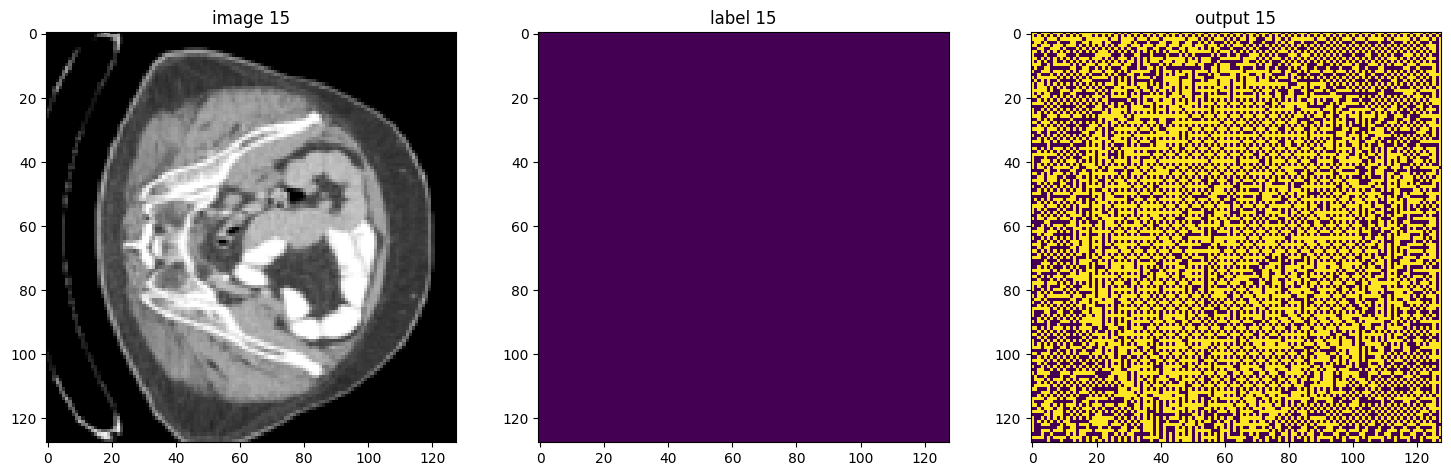

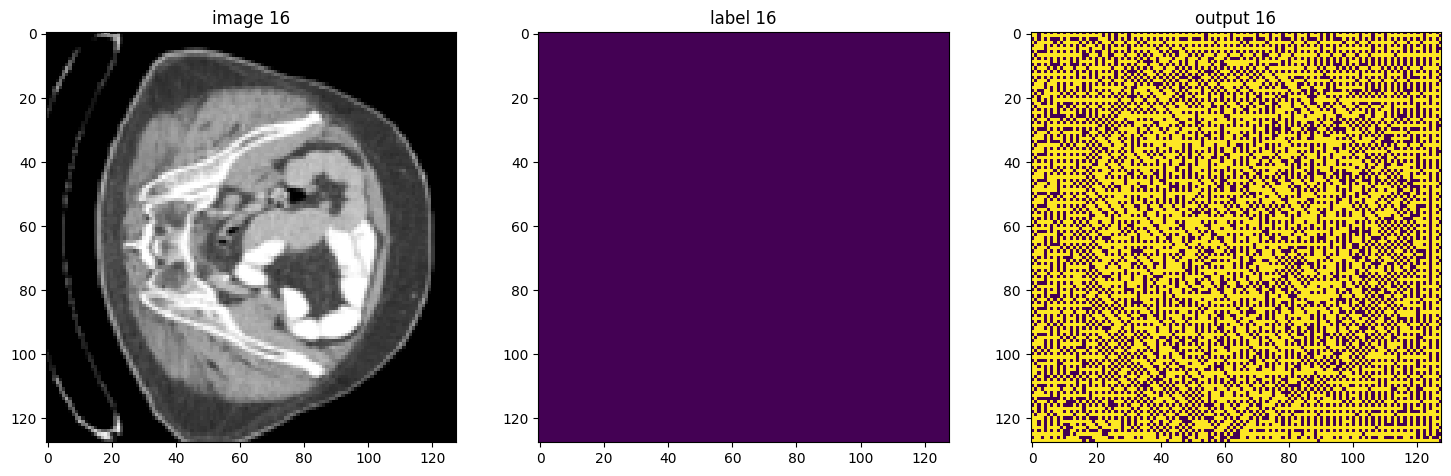

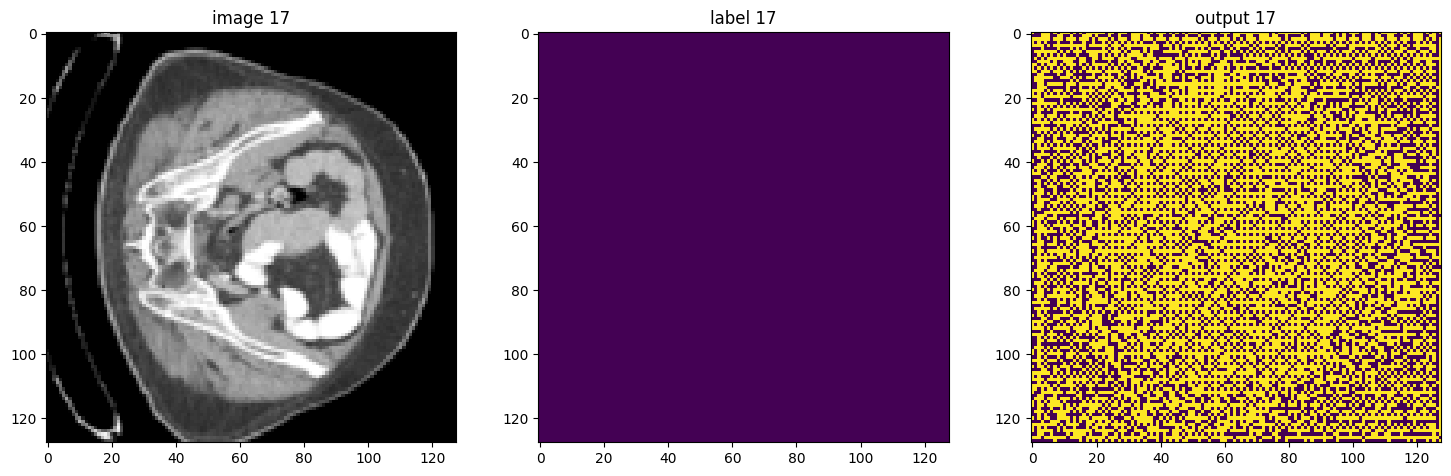

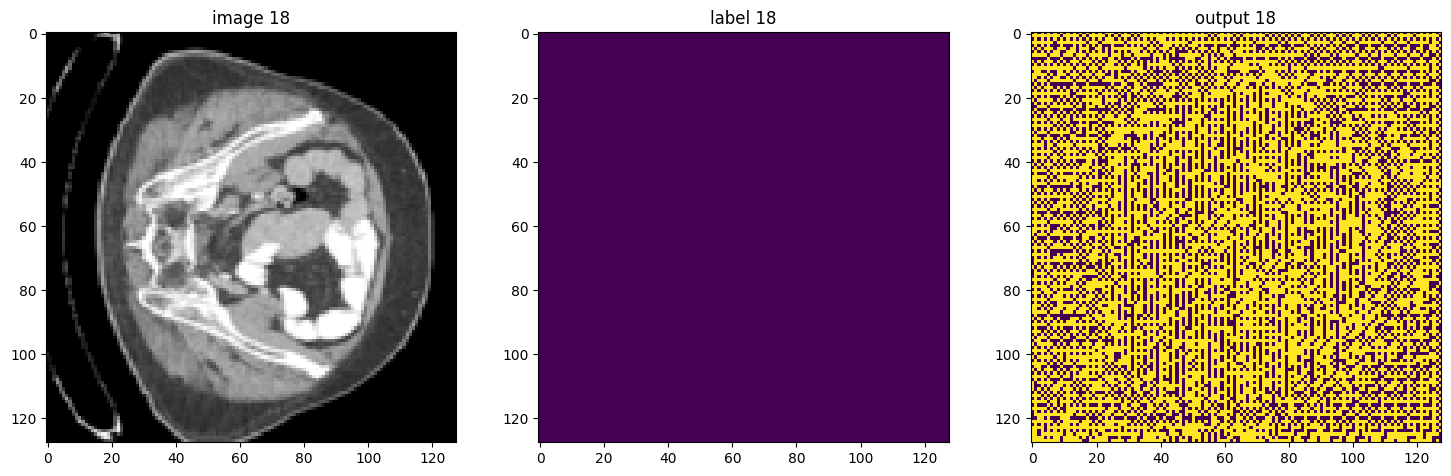

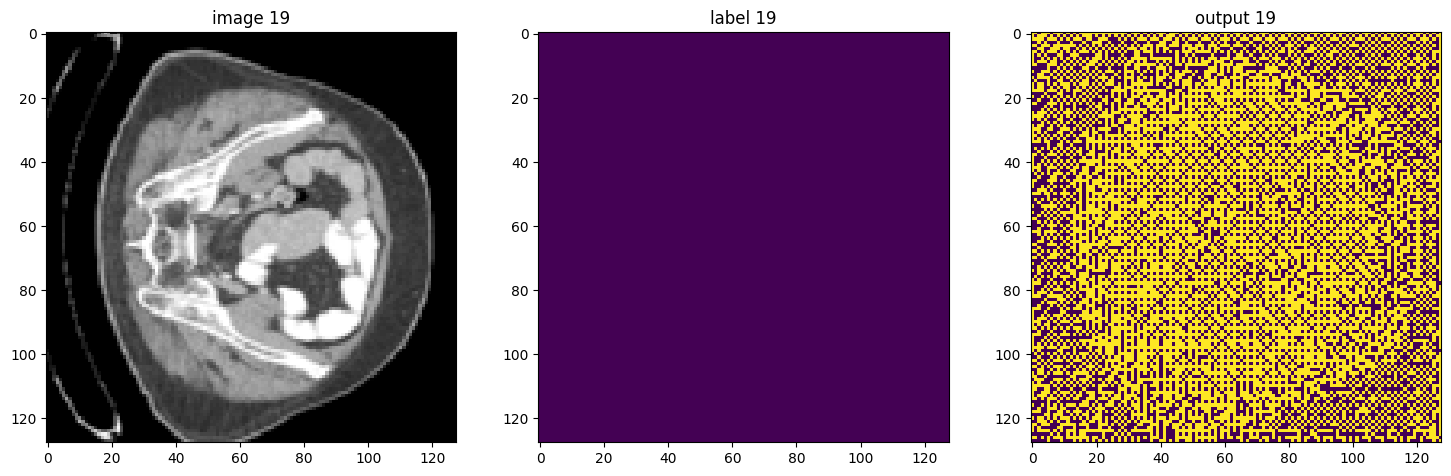

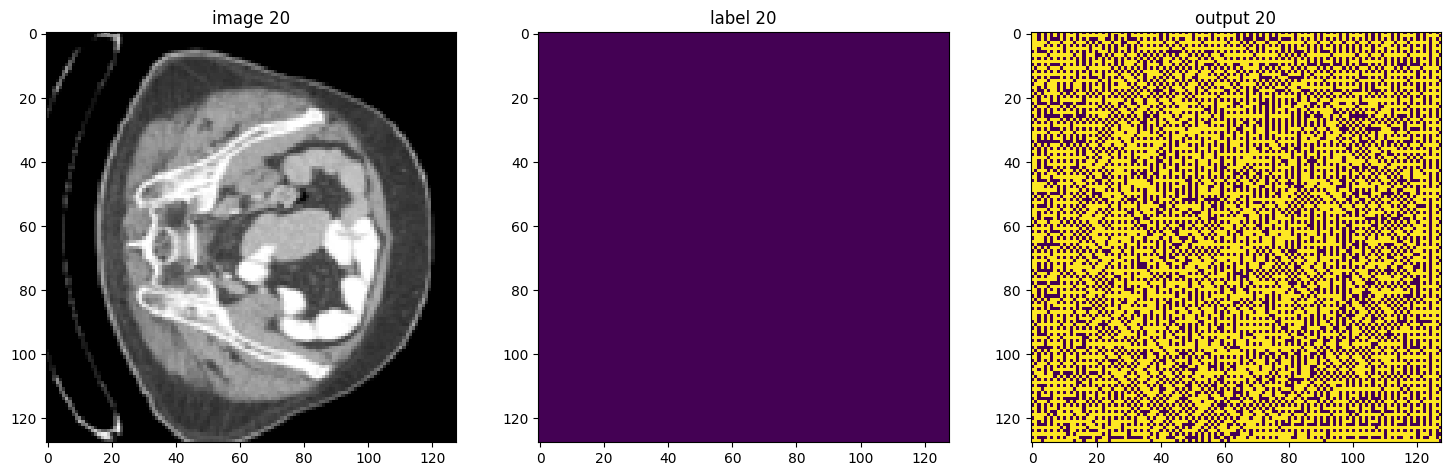

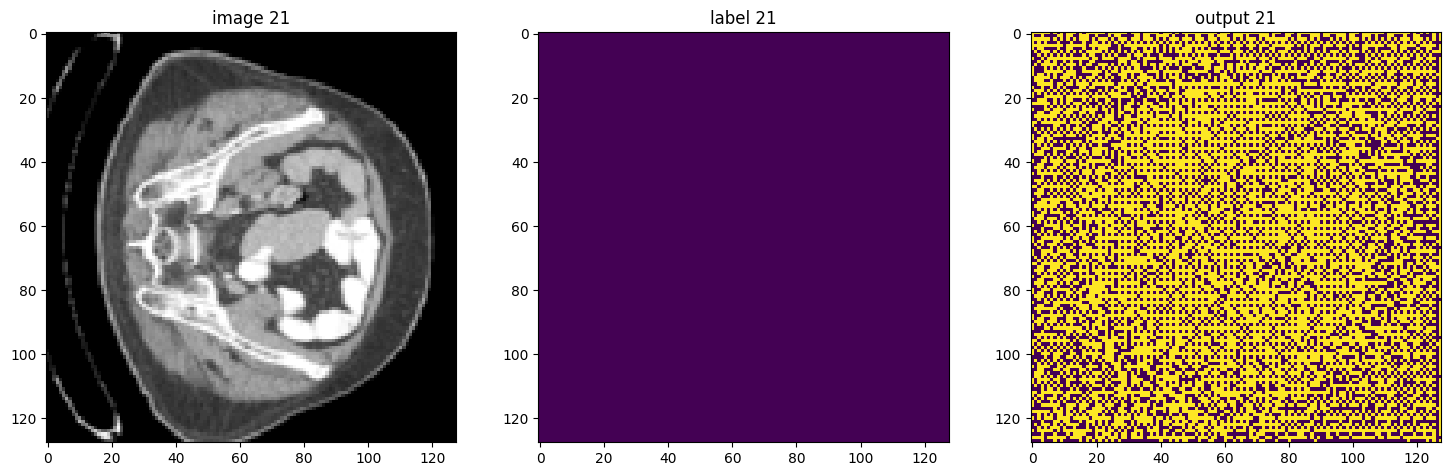

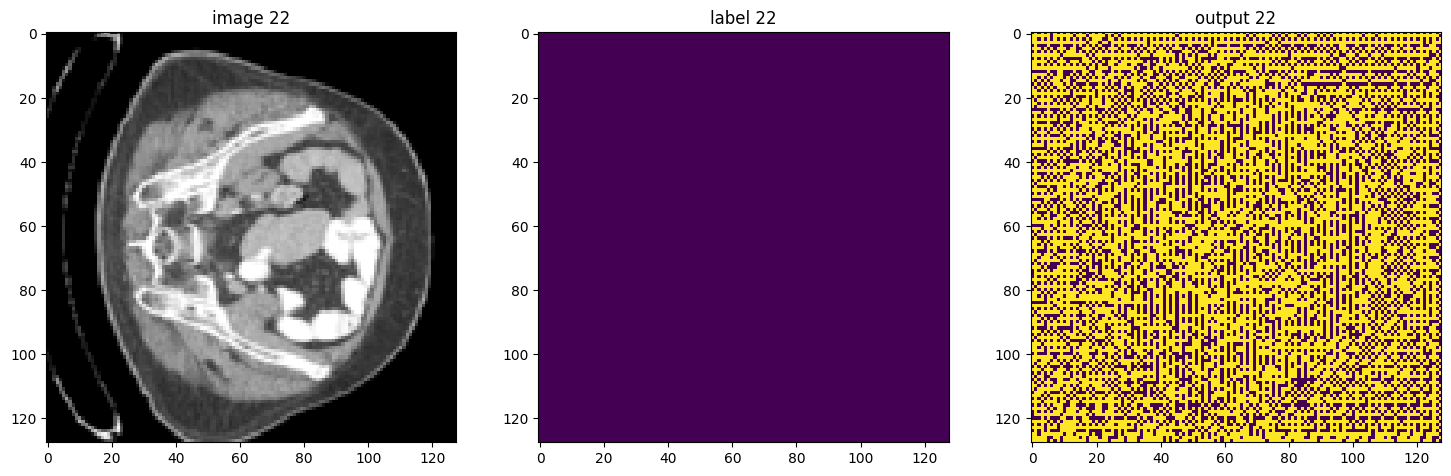

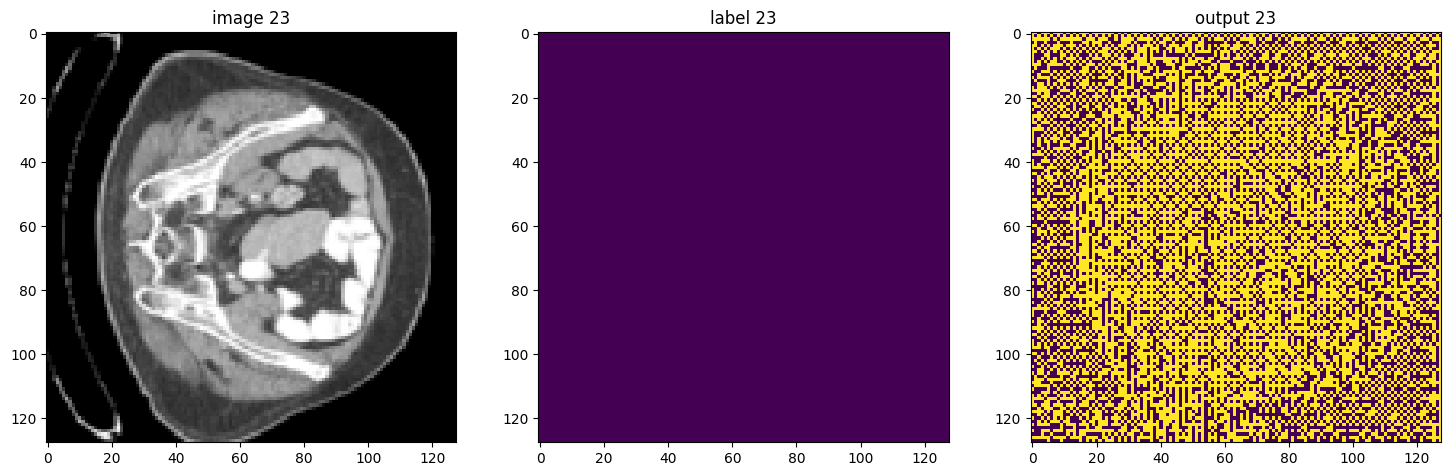

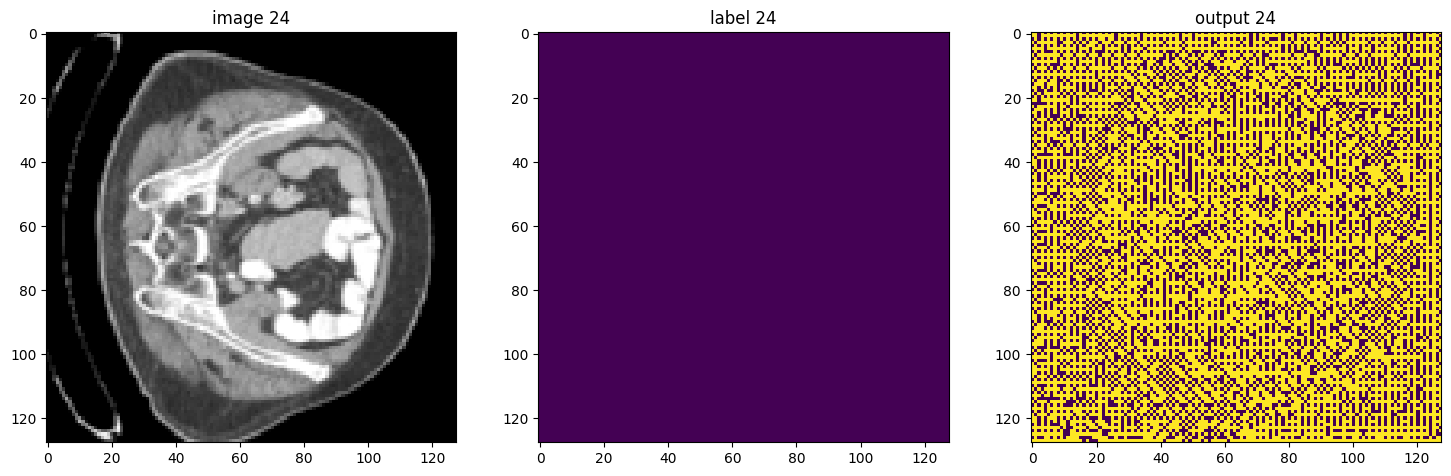

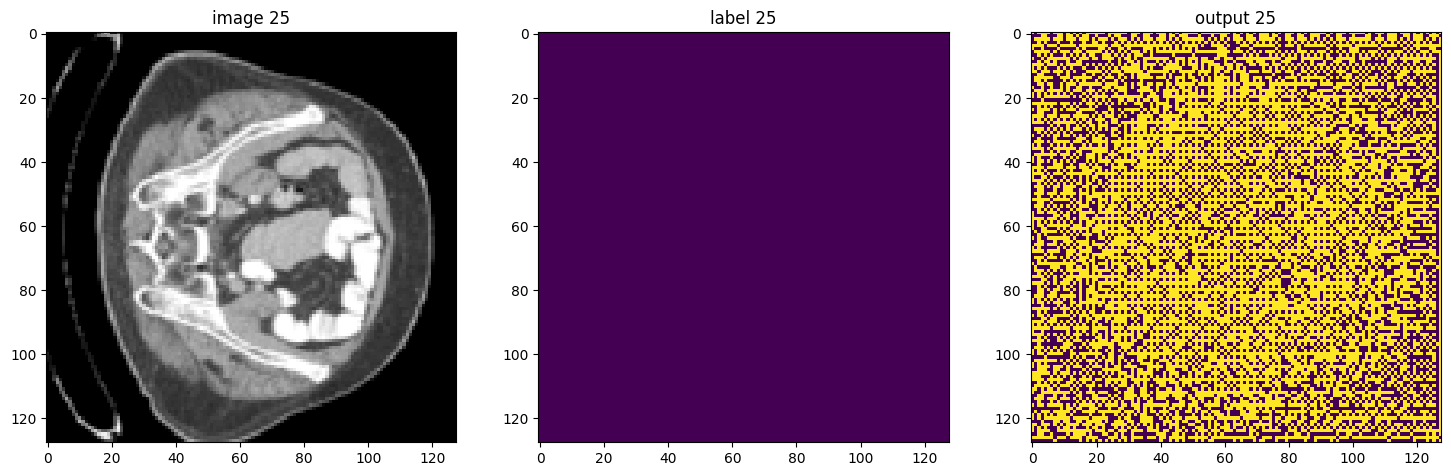

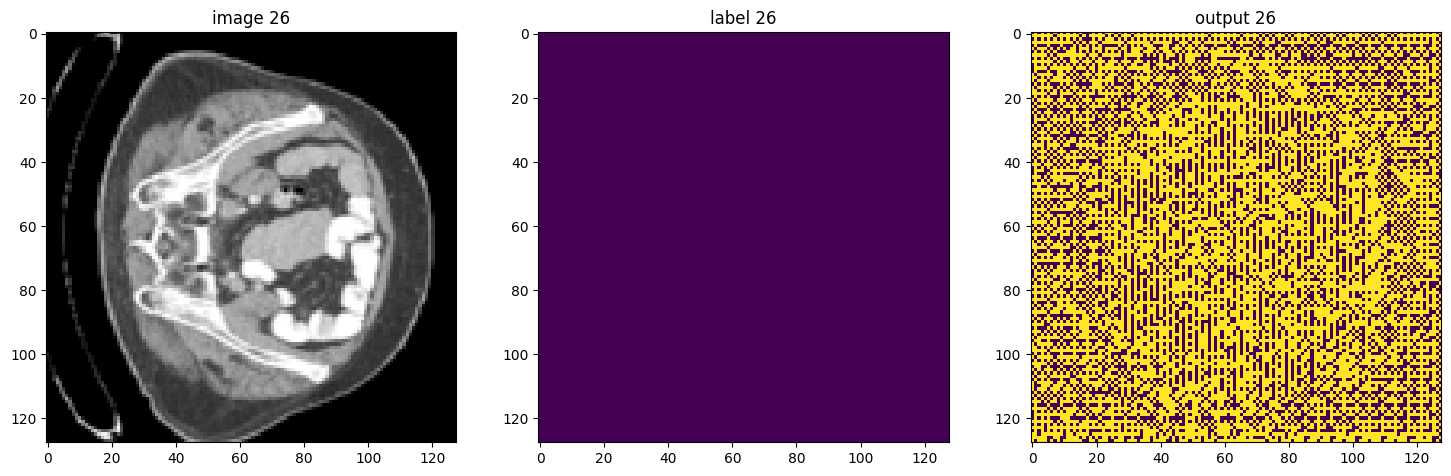

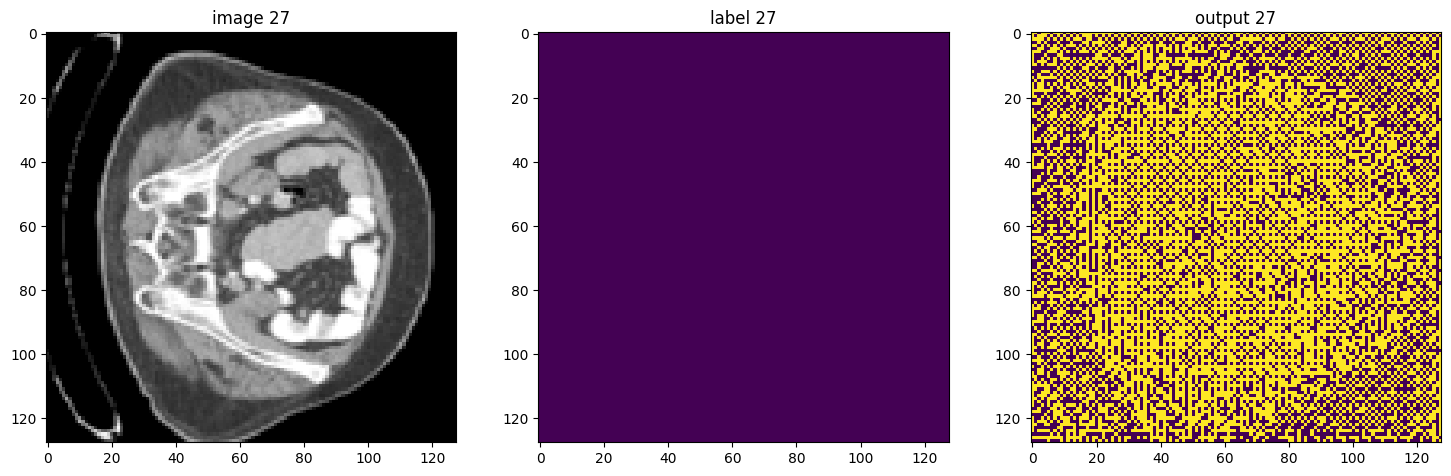

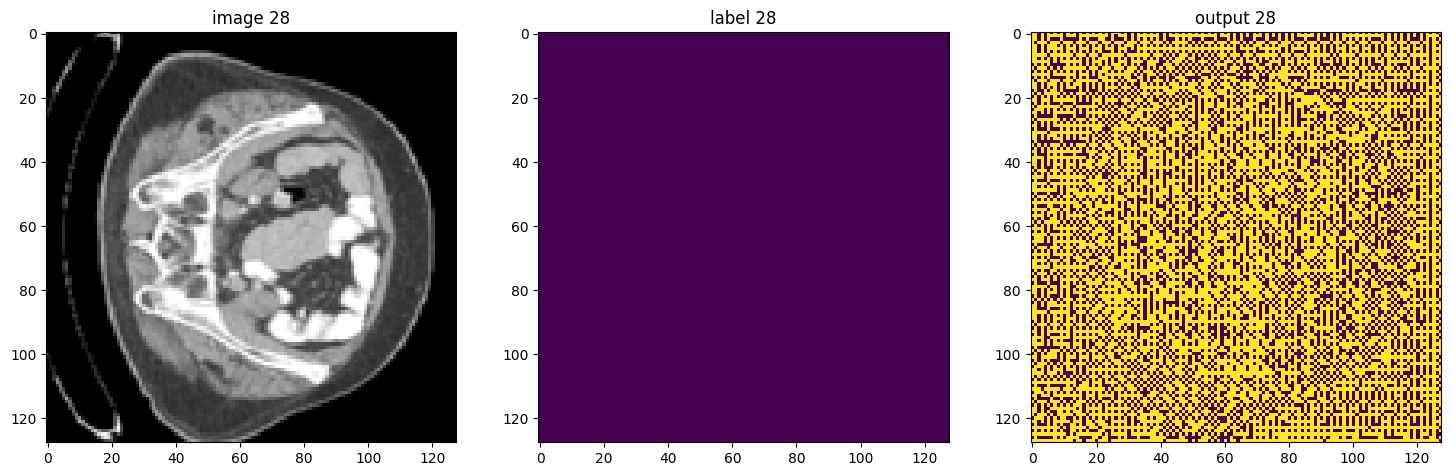

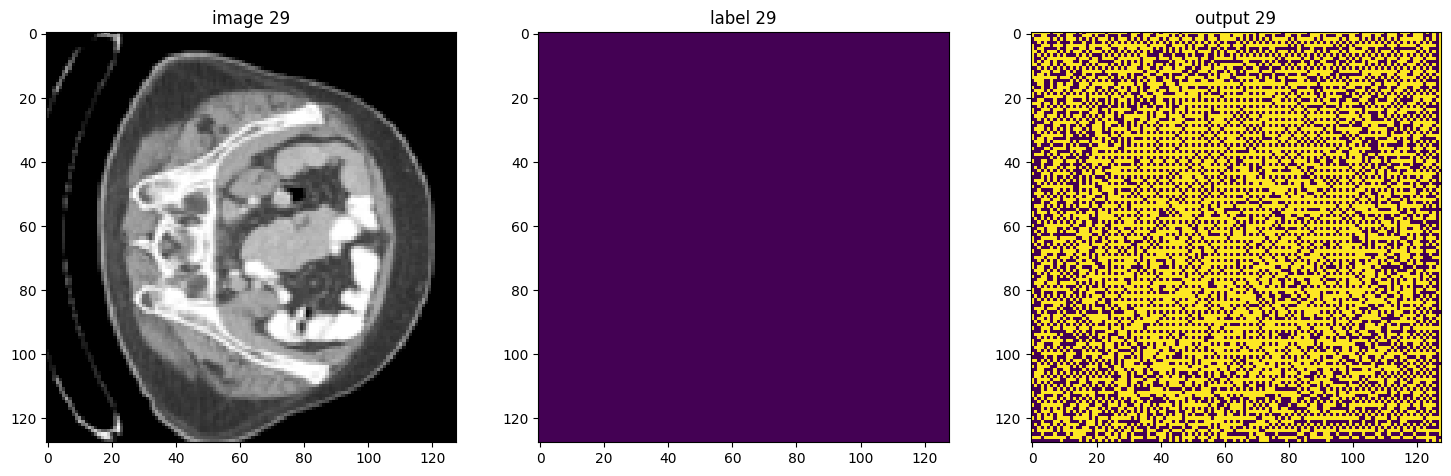

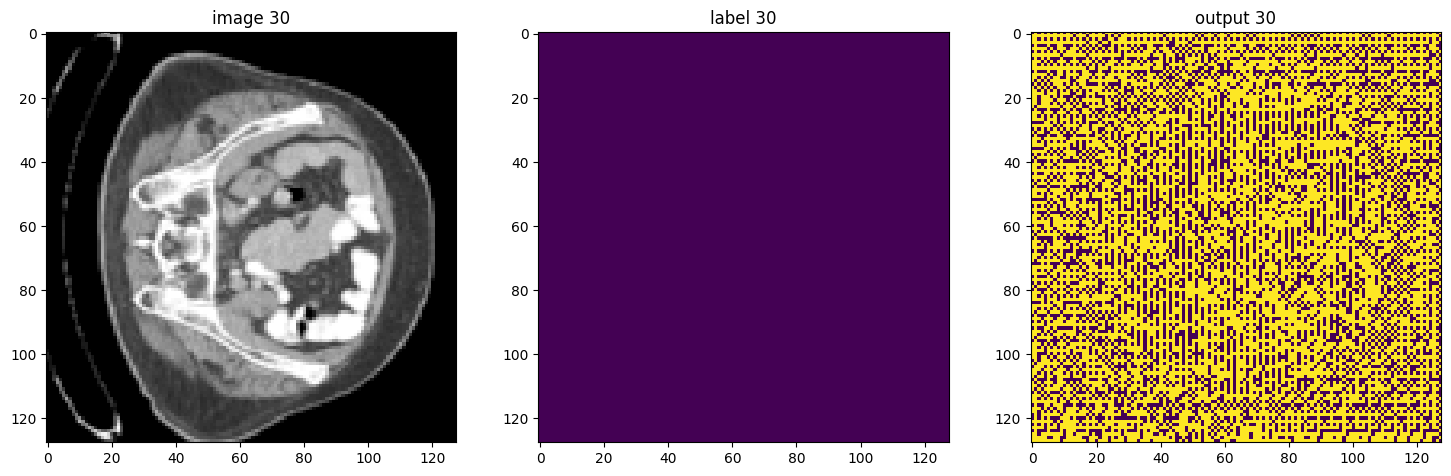

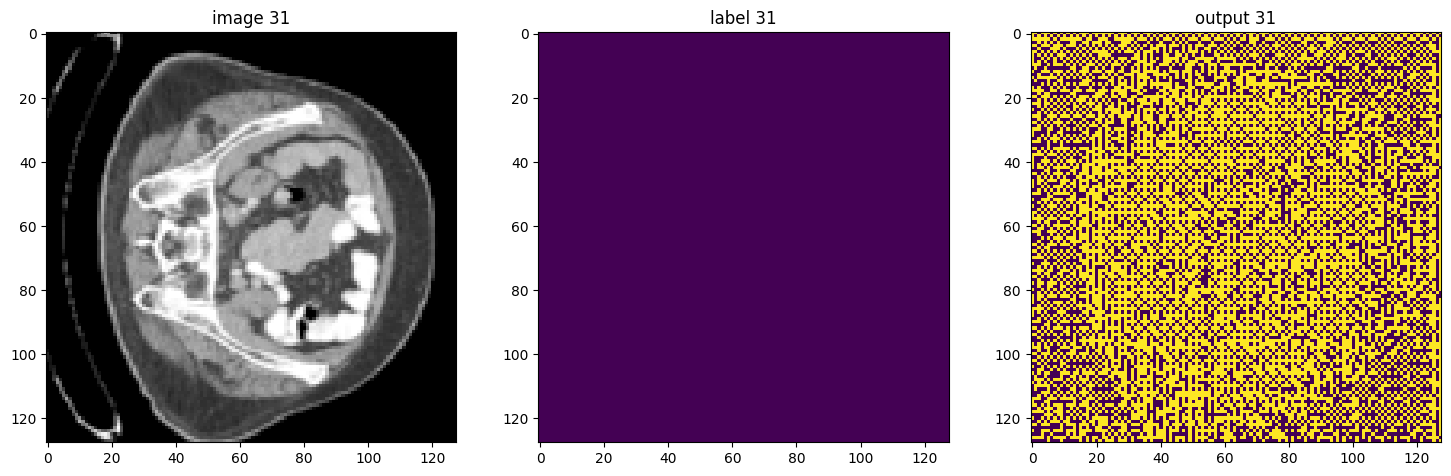

In [ ]:
sw_batch_size = 1
roi_size = (128, 128, 64)
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['vol']
    #t_segmentation = test_patient['seg']

    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.53

    for i in range(32):
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        plt.show()